In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0) Imports y config

In [2]:
import os, random
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-08-17 20:21:56.044602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755462116.400908      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755462116.499724      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
SEED       = 42
IMG_SIZE   = 160
BATCH_SIZE = 64
EPOCHS     = 200
DATA_DIR   = '/kaggle/input/utkface-new/UTKFace/'
VAL_SPLIT  = 0.10
TEST_SPLIT = 0.10
MAX_AGE    = 100               # rango esperado 0..100
random.seed(SEED); tf.random.set_seed(SEED)

# 1) Datos y pipeline

In [4]:
def parse_age_from_filename(path):
    fname = tf.strings.split(path, os.sep)[-1]
    age_str = tf.strings.split(fname, "_")[0]
    return tf.strings.to_number(age_str, tf.float32)

In [5]:
def load_img_and_age(path):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img_bytes, channels=3)      # RGB
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32) # [0,1]
    age = parse_age_from_filename(path)
    # recorte/alineación: si usas mediapipe, hazlo fuera o con tf.py_function
    return img, age

In [6]:
# Codifica edad continua -> vector ordinal (K-1)
def to_ordinal(age, num_classes=MAX_AGE+1):
    k = num_classes - 1
    # vector [1,1,1,...,0,0] donde 1 si age > t, t=0..k-1
    t = tf.range(k, dtype=tf.float32)
    return tf.cast(age[:, None] > t[None, :], tf.float32)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

I0000 00:00:1755462134.930377      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755462134.931128      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
def make_file_splits():
    files = []
    for ext in ("*.jpg","*.jpeg","*.png"):
        files += list(Path(DATA_DIR).glob(ext))
    files = [str(p) for p in files]
    random.shuffle(files)
    N = len(files); n_test=int(N*TEST_SPLIT); n_val=int(N*VAL_SPLIT)
    return files[:N-n_val-n_test], files[N-n_val-n_test:N-n_test], files[N-n_test:]

train_files, val_files, test_files = make_file_splits()

In [9]:
def make_ds(filepaths, training):
    ds = tf.data.Dataset.from_tensor_slices(filepaths)
    if training:
        ds = ds.shuffle(min(len(filepaths), 2000), seed=SEED)
    ds = ds.map(load_img_and_age, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    # targets: {'ord_logits': vector ordinal, 'age_pred': edad escalar}
    def pack_targets(img, age):
        ord_vec = to_ordinal(tf.reshape(age, [-1]))
        targets = {"ord_logits": ord_vec, "age_pred": tf.reshape(age, [-1,1])}
        return img, targets
    ds = ds.batch(BATCH_SIZE).map(pack_targets, num_parallel_calls=AUTOTUNE)

    # sample_weight: más peso a <20 y opcional >60
    def add_weights(img, targets):
        age = targets["age_pred"]
        w = tf.where(age < 20, 2.0, 1.0)
        w = tf.where(age >= 60, 1.5, w)
        return img, targets, w
    if training:
        ds = ds.map(add_weights, num_parallel_calls=AUTOTUNE)

    return ds.prefetch(AUTOTUNE)

In [10]:
train_ds = make_ds(train_files, training=True)
val_ds   = make_ds(val_files, training=False)
test_ds  = make_ds(test_files, training=False)

# 2) Backbone residual

In [11]:
def conv_bn_act(x, f, k=3, s=1):
    x = layers.Conv2D(f, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.Activation("swish")(x)

In [12]:
def block(x, f, s=1):
    h = conv_bn_act(x, f, 3, s)
    h = conv_bn_act(h, f, 3, 1)
    if x.shape[-1] != f or s != 1:
        x = layers.Conv2D(f, 1, strides=s, use_bias=False, padding="same")(x)
        x = layers.BatchNormalization()(x)
    h = layers.Add()([h, x])
    return layers.Activation("swish")(h)

# 3) Head CORAL (ordinal)

In [13]:
class CoralOrdinal(layers.Layer):
    """Head CORAL: comparte w y aprende biases por umbral; devuelve logits (B, K-1)."""
    def __init__(self, num_classes, name="coral"):
        super().__init__(name=name)
        self.num_classes = num_classes

    def build(self, input_shape):
        d = int(input_shape[-1])
        self.w = self.add_weight(
            name="w", shape=(d, 1), initializer="glorot_uniform", trainable=True
        )
        self.b = self.add_weight(
            name="b", shape=(self.num_classes - 1,), initializer="zeros", trainable=True
        )

    def call(self, x):
        base = tf.linalg.matmul(x, self.w)        # (B,1)
        return base + self.b                      # broadcast -> (B, K-1)

In [14]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=MAX_AGE+1):
    inp = keras.Input(shape=input_shape)

    x = conv_bn_act(inp, 32, 3, 2)
    x = block(x, 32); x = block(x, 32)
    x = block(x, 64, 2); x = block(x, 64)
    x = block(x, 128, 2); x = block(x, 128); x = block(x, 128)
    x = block(x, 256, 2); x = block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="swish")(x)
    x = layers.Dropout(0.2)(x)

    ord_logits = CoralOrdinal(num_classes, name="ord_logits")(x)           # (B,K-1)
    # Edad esperada = suma(sigmoid(logits))  (0..K-1)
    age_pred = layers.Lambda(lambda z: tf.reduce_sum(tf.nn.sigmoid(z), axis=1, keepdims=True),
                             name="age_pred")(ord_logits)
    return keras.Model(inp, outputs=[ord_logits, age_pred], name="AgeCORAL")

model = build_model()
model.summary()

Model: "AgeCORAL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 80,    │          0 │ activation_2[0][… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 80, 80,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_4[0][0]  

 Total params: 3,161,924 (12.06 MB)

 Trainable params: 3,156,612 (12.04 MB)

 Non-trainable params: 5,312 (20.75 KB)

# 4) Compilar y entrenar

In [15]:
# Pérdida ordinal en logits (numéricamente estable)
bce_logits = keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(
    optimizer=optimizer,
    loss={"ord_logits": bce_logits, "age_pred": None},  # sin pérdida para la salida 'age_pred'
    metrics={"age_pred": [keras.metrics.MeanAbsoluteError(name="mae"),
                          keras.metrics.RootMeanSquaredError(name="rmse")]},
)

ckpt = keras.callbacks.ModelCheckpoint("best_coral.keras",
                                       monitor="val_age_pred_mae",
                                       save_best_only=True, mode="min")
lrplateau = keras.callbacks.ReduceLROnPlateau(monitor="val_age_pred_mae",
                                              patience=5, factor=0.5, min_lr=1e-6, mode="min", verbose=1)
early = keras.callbacks.EarlyStopping(monitor="val_age_pred_mae",
                                      patience=15, restore_best_weights=True, mode="min", verbose=1)


In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, lrplateau, early],
    verbose=1
)

Epoch 1/200


I0000 00:00:1755462158.927388     107 service.cc:148] XLA service 0x7e313002e960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755462158.928992     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755462158.929027     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755462161.415530     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755462173.272275     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 468ms/step - age_pred_mae: 16.2955 - age_pred_rmse: 21.2707 - loss: 0.7854 - val_age_pred_mae: 14.0491 - val_age_pred_rmse: 19.0643 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 2/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 296ms/step - age_pred_mae: 13.5345 - age_pred_rmse: 17.8566 - loss: 0.6370 - val_age_pred_mae: 14.4870 - val_age_pred_rmse: 18.6644 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 3/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 296ms/step - age_pred_mae: 9.8970 - age_pred_rmse: 13.3521 - loss: 0.5187 - val_age_pred_mae: 12.9325 - val_age_pred_rmse: 18.7539 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 4/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 295ms/step - age_pred_mae: 8.7816 - age_pred_rmse: 12.0147 - loss: 0.4598 - val_age_pred_mae: 8.0623 - val_age_pred_rmse: 11.4096 - val_loss: 0.3564 - learning_rate: 0.0010
Epoch 5/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 87s 294ms/step - age_pred_mae: 8.3809 - age_pred_rmse: 11.5914 - loss: 0.4174 - val_age_pred_

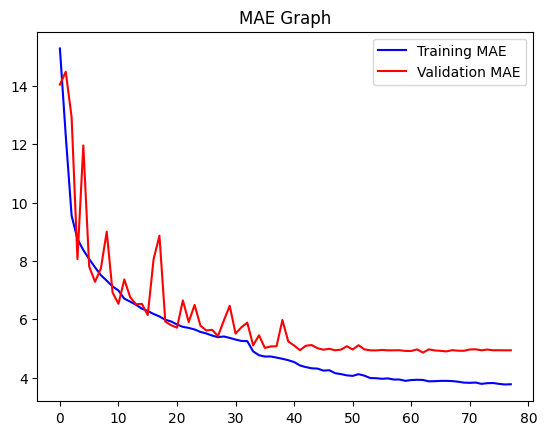

In [17]:
# plot results for age
import matplotlib.pyplot as plt
loss = history.history['age_pred_mae']
val_loss = history.history['val_age_pred_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('MAE Graph')
plt.legend()
plt.show()

# 5) Evaluación en test

In [18]:
# Obtenemos y_true e y_pred (desde el head age_pred)
y_true, y_pred = [], []
for (imgs, targets) in test_ds:
    preds = model.predict(imgs, verbose=0)
    # preds = [ord_logits, age_hat]; tomamos age_hat
    y_pred.append(preds[1].squeeze())
    y_true.append(targets["age_pred"].numpy().squeeze())
y_true = np.concatenate(y_true).astype(np.float32)
y_pred = np.concatenate(y_pred).astype(np.float32)

mae  = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true)**2))
medae = np.median(np.abs(y_pred - y_true))
ss_res = np.sum((y_true - y_pred)**2); ss_tot = np.sum((y_true - y_true.mean())**2)
r2 = 1 - ss_res/ss_tot
print({"MAE":mae, "RMSE":rmse, "MedAE":medae, "R2":r2})

{'MAE': 4.870012, 'RMSE': 6.9970317, 'MedAE': 3.2541885, 'R2': 0.8744589239358902}


In [19]:
def cs_at_k(y_true, y_pred, K):
    return float(np.mean(np.abs(y_pred - y_true) <= K))
for k in [2,3,5,7,10]:
    print(f"CS@{k} = {cs_at_k(y_true, y_pred, k):.3f}")

CS@2 = 0.352
CS@3 = 0.476
CS@5 = 0.642
CS@7 = 0.764
CS@10 = 0.867


In [22]:
os.makedirs('/kaggle/working/models', exist_ok=True)